In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
port_path = "Prueba.xlsx"
market = pd.read_excel(port_path, index_col=0)

In [4]:
rets = market.pct_change().dropna(axis=0)
rets.columns = [col.replace(" MF Equity", "") for col in rets.columns]

In [5]:
Phi = rets.iloc[:, :-1].values
t = rets.iloc[:, [-1]]
N, M = Phi.shape

I = np.concatenate([np.identity(M)] * 2, axis=1)
I = np.concatenate([I] * 2, axis=0)

In [6]:
P = np.ones((N, M))
P = np.c_[P, Phi]

In [7]:
W = np.linalg.inv((P.T @ P) * I) @ P.T @ t
W["security"]  = np.concatenate([rets.columns[:-1]] * 2)
W["param"] = ["alpha"] * M + ["beta"] * M
B = W.pivot_table(index="security", columns="param", values="MEXBOL INDEX")

In [8]:
port_path = "PreciosPortf.xlsx"
data = pd.read_excel(port_path, index_col=0)

rend = data.pct_change().dropna()

In [9]:
def port_rend(weights, r):
    E_p = (r.mean() @ weights) * 252
    return E_p

def port_vol(weights, r):
    S_p = np.sqrt(weights.T @ (r.cov() * 252) @ weights)
    return S_p

In [10]:
weights_sim = np.random.random((5000, 5))
weights_sim = weights_sim / weights_sim.sum(axis=1, keepdims=True)

rend_sim = np.apply_along_axis(port_rend, 1, weights_sim, r=rend)
vol_sim = np.apply_along_axis(port_vol, 1, weights_sim, r=rend)

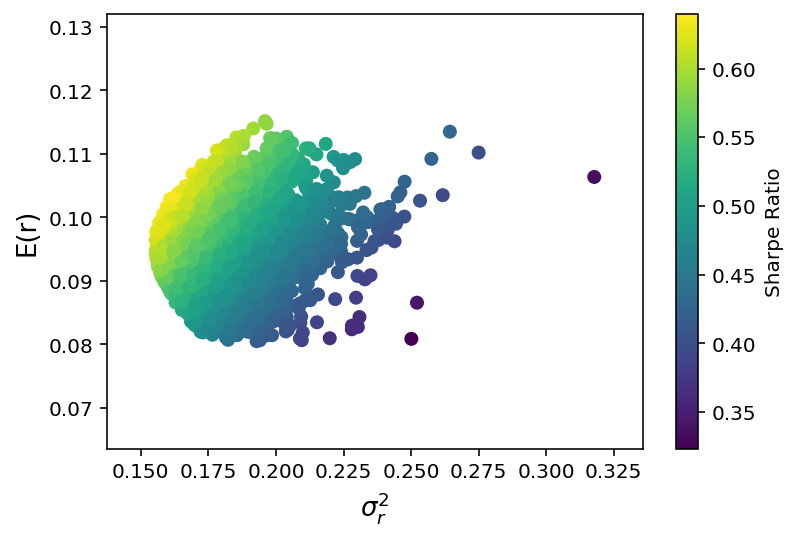

In [11]:
sharpe_ratio = rend_sim / vol_sim
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)", fontsize=13);

In [12]:
from scipy.optimize import minimize

In [26]:
N, M = rend.shape
w0  = np.random.randn(M)

def sum_weights(weights):
    return weights.sum() - 1 # == 0

def rend_esperado(w, E):
    return port_rend(w, rend) - E # == 0

#Función para definir restricción en la que los pesos 1 y 2 sumen 10%
def sum_weights_12(weights):
    return weights[0] + weights[1] - 0.1

constraints = [
    {"type": "eq", "fun": sum_weights}
]

port0 = minimize(port_vol, w0, constraints=constraints, args=rend)
wp0 = port0.x

In [23]:
rend_ports = rend.mean() * 252
#r_min = port_rend(wp0, rend)
r_min = rend_ports.min()
r_max = rend_ports.max()

rend_max = np.linspace(r_min, r_max)

In [34]:
pesos_optimos = []
for e in rend_max:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w: rend_esperado(w, e)}
    ]

    port1 = minimize(port_vol, w0, constraints=constraints, args=rend)
    w_opt = port1.x
    pesos_optimos.append(w_opt)

In [35]:
pesos_optimos2 = []
for e in rend_max:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w: rend_esperado(w, e)},
        {"type": "eq", "fun": sum_weights_12}
    ]

    port1 = minimize(port_vol, w0, constraints=constraints, args=rend)
    w_opt = port1.x
    pesos_optimos2.append(w_opt)

In [36]:
r_opt = []
v_opt = []
for w in pesos_optimos:
    r_opt.append(port_rend(w, rend))
    v_opt.append(port_vol(w, rend))

r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

r_opt2 = []
v_opt2 = []
for w in pesos_optimos2:
    r_opt2.append(port_rend(w, rend))
    v_opt2.append(port_vol(w, rend))

r_opt2 = np.array(r_opt2)
v_opt2 = np.array(v_opt2)

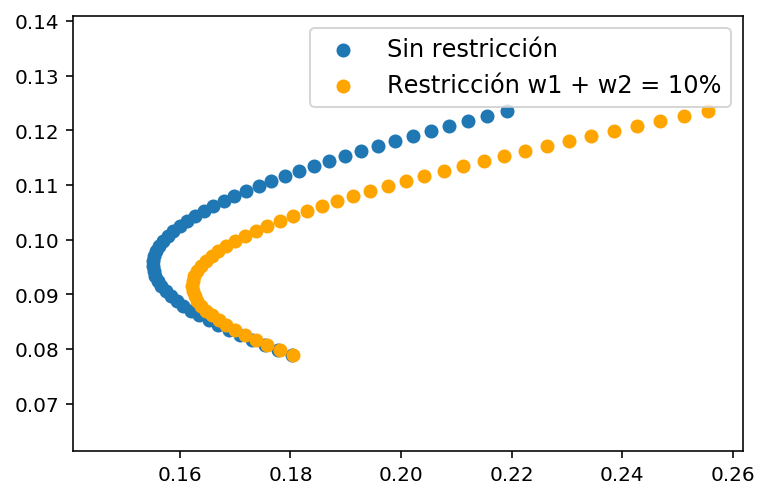

In [40]:
plt.scatter(v_opt, r_opt, label="Sin restricción");
plt.scatter(v_opt2, r_opt2, c="orange", label="Restricción w1 + w2 = 10%");
plt.legend(fontsize=12);